In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
import numpy as np
from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import scipy.stats as sts

import scipy.io as sio
import pickle

import pandas as pd

from scipy.signal import savgol_filter

from roiVisualization import myAxisTheme, plotDFFROIs, plotDFF_PVA_heading_fwdvelo, minimalAxisTheme
from imagingPreProc import *
from imagingVeloCorrAnalysis import *

In [2]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## Specify experimental settings and import imaging info from single tif header

In [304]:
driver = 'SS78'
effector = 'GCaMP7f'
genotype = '_'.join([driver,effector])
region = 'FB'

numTrials = 3

dataDir = '/Users/haberkernh/Desktop/PathInteg_withDan/{}_x_{}/closedLoopStim'.format(effector, driver) #
conditions = ['dark', 'stripe', 'groundPl']
#['blackFlatGround', 'blackFinetexGround', 'stripeFlatGround', 'stripeFinetexGround']

In [306]:
minLine = 10
lc = 0

flyID = 'f04'
age = '4-5'
stem2 = '{}_{}_{}d_{}'.format(genotype,flyID,age,region)

with open(sep.join([dataDir,'rawData','imaging',flyID,''])+ '_'.join([stem2, conditions[0],str(1).zfill(5)])+'.tif', 'rb') as fh:
    endofhead = 0 
    fpv = -1
    while(not endofhead):
        line = str(fh.readline()[:-1])
        lc += 1
        # get channel info
        if 'channelSave' in line:
            lineString = str(line)
            if not '[' in lineString: nCh = 1
            else: nCh = int(lineString.split('[')[-1][-2])
        
        if 'scanFrameRate' in line:
            lineString = str(line)
            fpsscan = float(lineString[lineString.find('=')+1:-1])
        
        if 'hFastZ' in line:
            if 'discardFlybackFrames' in line:
                lineString = str(line)
                discardFBFrames = lineString[lineString.find('=')+1:-1]
                
            if 'numDiscardFlybackFrames' in line:
                lineString = str(line)
                nDiscardFBFrames = int(lineString[lineString.find('=')+1:-1])
                
            if 'numFramesPerVolume' in line:
                lineString = str(line)
                fpv = int(lineString[lineString.find('=')+1:-1])
            if 'numVolumes' in line:
                lineString = str(line)
                nVols = int(lineString[lineString.find('=')+1:-1])
        
        if not 'SI' in line and lc > minLine: endofhead = 1
print(' # channels: {}\n fly back? {}\n # discard frames: {}\n # frames/volume: {}\n # volumes: {}'.\
      format(nCh, discardFBFrames, nDiscardFBFrames, fpv, nVols))

caCh = nCh-1
vps =  fpsscan/fpv #volumes per second = fpv / fpsscan
print('frame rate per volume [Hz]: {}'.format(vps))

 # channels: 1
 fly back?  true
 # discard frames: 2
 # frames/volume: 12
 # volumes: 900
frame rate per volume [Hz]: 7.131883333333334


# Preprossessing data from single fly
### 0. Parameter settings

In [307]:
flyID = 'f09'
age = '4-5d'

stem = '{}_{}_{}'.format(genotype, flyID, region)
pltstem = '{}_{}_{}_{}'.format(genotype, flyID, age, region)

computeDFF = False # False: DFF already computed with Matlab script

trialCols = ['peru','yellowgreen','teal']

if genotype == 'SS52577_GCaMP7b' or genotype == 'SS81_GCaMP7f':
    FBRois = [0,1,2,3,4,5,6,7]
    NORois = [8,9]
else:
    NORois = [0,1]
    FBRois = [2,3,4,5,6,7,8,9]
numRois = 10

# Parameters for Savitzky-Golay Filter (for velocities and later for DFF)
sgorder = 3
sgwindow = 9

frameNum = nVols
vTransTH = 0.1

sgwindow = 11
sgorder = 3

arenarad = 100 # mm

In [308]:
plotDir = sep.join([dataDir,'analysis',flyID])
if not exists(plotDir):
    if not exists(sep.join([dataDir,'analysis'])):
        mkdir(sep.join([dataDir,'analysis']))
    mkdir(plotDir)
    
preprocsavedir = sep.join([dataDir,'preprocData',flyID,''])

### 1. Generate data frame with preprocessed data
#### Jump to (2), if data already has been preprocessed

In [309]:
roiArcPos = np.linspace(0, 2*np.pi, len(FBRois)+1)[:-1]


# Collect relevant data across trials in single data frame 
keylist = ['genotype','flyID','age','condition','trial',
            'time','tmtime',
            'heading', 'xpos', 'ypos', 'vRot', 'vFwd', 'vLat', 'vTrans', 
            'vTransFilt', 'vRotFilt', 'vFwdFilt', 'vLatFilt',
            'pvaROI', 'pvaRad', 'pvaLen']
keylist = keylist + ['NO{}'.format(i+1) for i in range(len(NORois))]
keylist = keylist + ['FB{}'.format(i+1) for i in range(len(FBRois))]
keylist = keylist + ['dffNO{}'.format(i+1) for i in range(len(NORois))]
keylist = keylist + ['dffFB{}'.format(i+1) for i in range(len(FBRois))]

#### First collect movement and raw F values from all trials, then compute normalization for DFF (for each trial)

In [310]:
singleFlyDf = pd.DataFrame()

baselines = np.zeros((len(conditions),numTrials, numRois))
        
for cond, condition in enumerate(conditions):
    for trial in range(numTrials):

        datName = '_'.join([pltstem, condition,str(trial+1).zfill(5)])+'.mat'
        print(datName)

        matDat = sio.loadmat(sep.join([dataDir,'preprocData',flyID,datName]))
        ROIdat = matDat['ROIaveMax']
        veldat = matDat['positionDat']
        numROIs = len(FBRois)

        # preprocess movement data
        vrDat, tmDeltas, FG =  parseMatPosdat(veldat, fpv)

        # filter velocities
        vTransFilt, vRotFilt, vFwdFilt, vLatFilt = filterVelos(vrDat, sgwindow, sgorder)

        # time for imaging and plotting
        #roitime = np.linspace(0, nVols/vps, nVols)

        # collect all raw flourescence data to compute baseline and subsequently DFF over all trials
        ROIdatMatch = ROIdat[:,FG[0]:FG[1]]
        
        # Add values to the data dict
        vrDat['vTransFilt'] = vTransFilt
        vrDat['vRotFilt'] = vRotFilt
        vrDat['vFwdFilt'] = vFwdFilt
        vrDat['vLatFilt'] = vLatFilt
        
        # construct data frame
        singleTrialdf = pd.DataFrame(vrDat)
        singleTrialdf['genotype'] = genotype
        singleTrialdf['flyID'] = flyID
        singleTrialdf['age'] = age
        singleTrialdf['condition'] = condition
        singleTrialdf['trial'] = trial+1

        # add annotated ROI data
        for i in range(len(NORois)):
            singleTrialdf['NO{}'.format(i+1)] = ROIdatMatch[NORois[i],:]
            
        for i in range(len(FBRois)):
            singleTrialdf['FB{}'.format(i+1)] = ROIdatMatch[FBRois[i],:]
            
        
        # DFF calculation
        baseLinePercent = 5
        offset = 0.0001

        # preprocess imaging data: 
        # (a) Compute DFF from preprocessed ROI data (mean flourescence signal from individual ROIs
        #      after gaussian filtering raw signal). Do this ONLY if not already computed in Matlab script.
        # (b) Savitzky-Golay Filter DFF for each ROI
        
        for i in range(len(NORois)):
            if computeDFF:
                Fraw = np.squeeze(singleTrialdf['NO{}'.format(i+1)].values)
                Fraw = savgol_filter(Fraw, sgwindow, sgorder)

                # Estimate baseline
                F0 = np.percentile(Fraw, baseLinePercent)
                if F0 == 0: F0 += offset
                baselines[cond, trial, i] = F0

                # Compute dF/F_0 = (F_raw - F_0)/F_0
                dFF = (Fraw - F0) / F0

                # filter:
            else:
                dFF = np.squeeze(singleTrialdf['NO{}'.format(i+1)].values)
            dFFfilt = savgol_filter(dFF, sgwindow, sgorder)

            singleTrialdf['dffNO{}'.format(i+1)] = dFFfilt

        for i in range(len(FBRois)):
            if computeDFF:
                Fraw = np.squeeze(singleTrialdf['FB{}'.format(i+1)].values)
                Fraw = savgol_filter(Fraw, sgwindow, sgorder)

                # Estimate baseline
                F0 = np.percentile(Fraw, baseLinePercent)
                if F0 == 0: F0 += offset
                baselines[cond, trial, i+len(NORois)] = F0

                # Compute dF/F_0 = (F_raw - F_0)/F_0
                dFF = (Fraw - F0) / F0

            else:
                dFF = np.squeeze(singleTrialdf['FB{}'.format(i+1)].values)
                
            # filter:
            dFFfilt = savgol_filter(dFF, sgwindow, sgorder)

            singleTrialdf['dffFB{}'.format(i+1)] = dFFfilt

            
        singleFlyDf = singleFlyDf.append(singleTrialdf)

SS78_GCaMP7f_f09_4-5d_FB_dark_00001.mat
SS78_GCaMP7f_f09_4-5d_FB_dark_00002.mat
SS78_GCaMP7f_f09_4-5d_FB_dark_00003.mat
SS78_GCaMP7f_f09_4-5d_FB_stripe_00001.mat
SS78_GCaMP7f_f09_4-5d_FB_stripe_00002.mat
SS78_GCaMP7f_f09_4-5d_FB_stripe_00003.mat
SS78_GCaMP7f_f09_4-5d_FB_groundPl_00001.mat
SS78_GCaMP7f_f09_4-5d_FB_groundPl_00002.mat
SS78_GCaMP7f_f09_4-5d_FB_groundPl_00003.mat


In [311]:
if computeDFF:
    fig, axs = plt.subplots(1,1,figsize=(4,3))
    trialCols = ['steelblue', 'peru', 'yellowgreen']
    condLine = [':', '--', '-']
    for cond, condition in enumerate(conditions):
        for trial in range(numTrials):
            axs.plot(baselines[cond, trial], color=trialCols[trial], linestyle=condLine[cond])

#### Compute PVA and add to dataframe

In [312]:
# Compute PVA
roidatFB = np.zeros((len(FBRois),len(singleFlyDf['dffFB1'].values)))
for i in range(len(FBRois)):
    roidatFB[i,:] = singleFlyDf['dffFB{}'.format(i+1)].values
pva = computePVA(roiArcPos,roidatFB)
pvaRad = np.arctan2(pva[1,:],pva[0,:])
pvaLen = np.hypot(pva[0,:],pva[1,:])

#TODO: figure out this number automatically!
PVAst = 0
pvaRoi = np.mod((np.unwrap(pvaRad,np.pi) - pvaRad[0]) * numROIs/(2*np.pi) + PVAst, numROIs)

# add some PVA data
singleFlyDf['pvaROI'] = pvaRoi
singleFlyDf['pvaRad'] = pvaRad
singleFlyDf['pvaLen'] = pvaLen

In [314]:
singleFlyDf = singleFlyDf[keylist]
singleFlyDf.to_pickle(preprocsavedir+'singleFlyPreproc_{}_{}_{}.pkl'.format(genotype, flyID, region))

### 2. Generate some visualizations

In [315]:
# load data
singleFlydf = pd.read_pickle(preprocsavedir+'singleFlyPreproc_{}.pkl'.format(stem))
savePlots = True

#### DFF over time

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is d

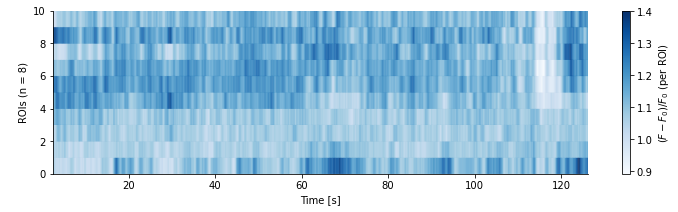

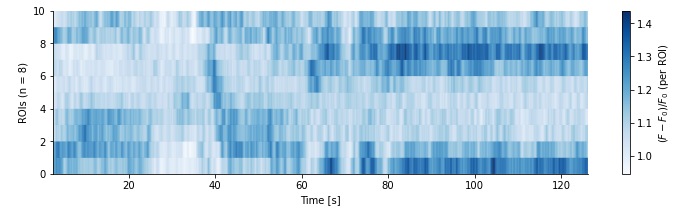

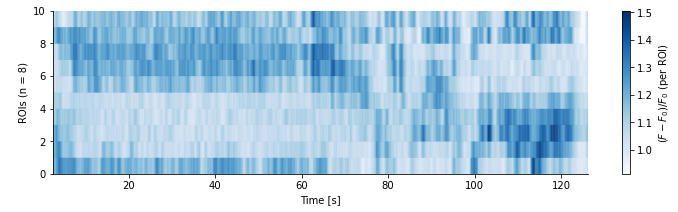

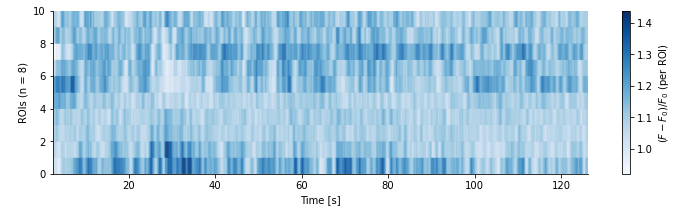

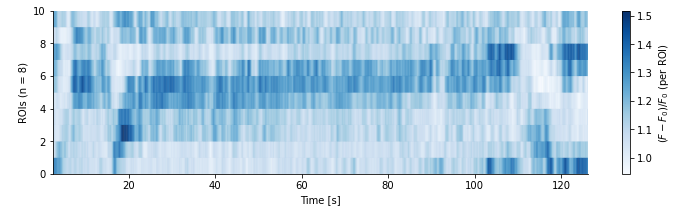

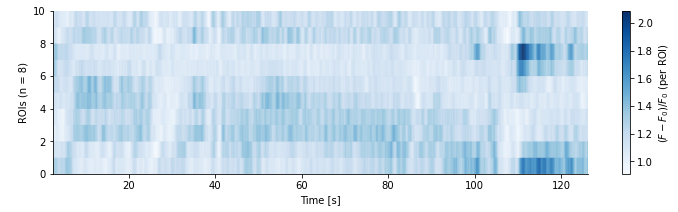

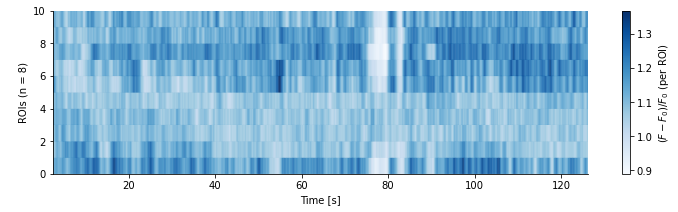

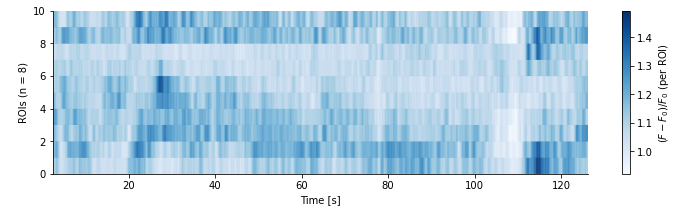

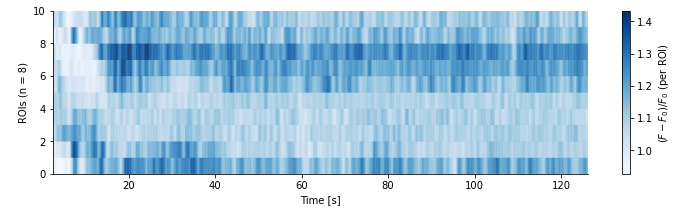

In [316]:
# Sanity check: Plot ROIs
for cond, condition in enumerate(conditions):
    for trial in range(3):
        subdf = singleFlydf.query('(condition == "{}") & ( trial == {})'.format(condition, trial+1))

        roidatFB = np.zeros((len(FBRois)+len(NORois),len(subdf['time'].values)))
        for i in range(len(FBRois)):
            roidatFB[i,:] = subdf['dffFB{}'.format(i+1)].values
        for i in range(len(NORois)):
            roidatFB[i+len(FBRois),:] = subdf['dffNO{}'.format(i+1)].values

        fig, axs = plt.subplots(1,1, figsize=(12,3))
        cax = axs.pcolor(subdf['time'].values,np.arange(0,len(FBRois)+len(NORois)+1),roidatFB,cmap='Blues', edgecolors='face')
        axs.set_xlabel('Time [s]')
        axs.set_ylabel('\nROIs (n = {0})'.format(len(FBRois)))
        myAxisTheme(axs)

        # Add colorbar, make sure to specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax)
        cbar.set_label('$(F - F_0) / F_0$ (per ROI)')  # vertically oriented colorbar
        fig.savefig(plotDir+sep+'{}_DFF_{}_t{}.pdf'.format(pltstem,condition, trial+1))

#### Walking trajectories

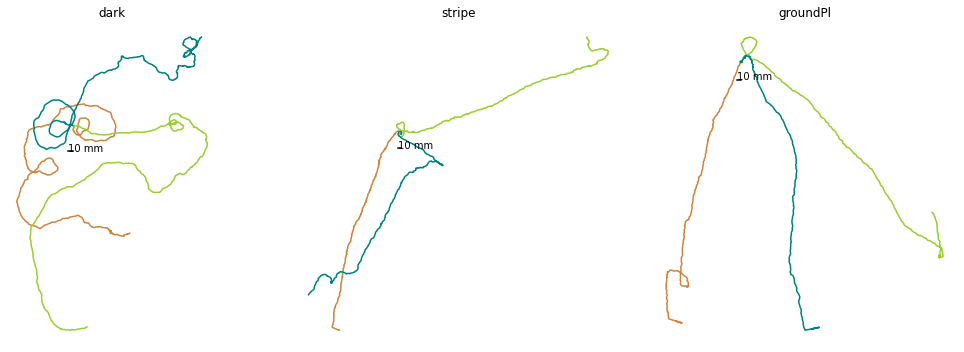

In [317]:
from roiVisualization import minimalAxisTheme

fig, axs = plt.subplots(1,len(conditions),figsize=(15,5))

for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        subdf = singleFlyDf.query('condition == "{}" & trial == {}'.format(condition, trial+1))
    
        axs[cond].plot(subdf['xpos'].values, subdf['ypos'].values, color=trialCols[trial],label='trial {}'.format(trial+1))
    minimalAxisTheme(axs[cond],1,([-6, -5]),'10 mm')
    axs[cond].set_title(condition)

    fig.tight_layout()
fig.savefig(plotDir+sep+'{}_trajectories.pdf'.format(pltstem))

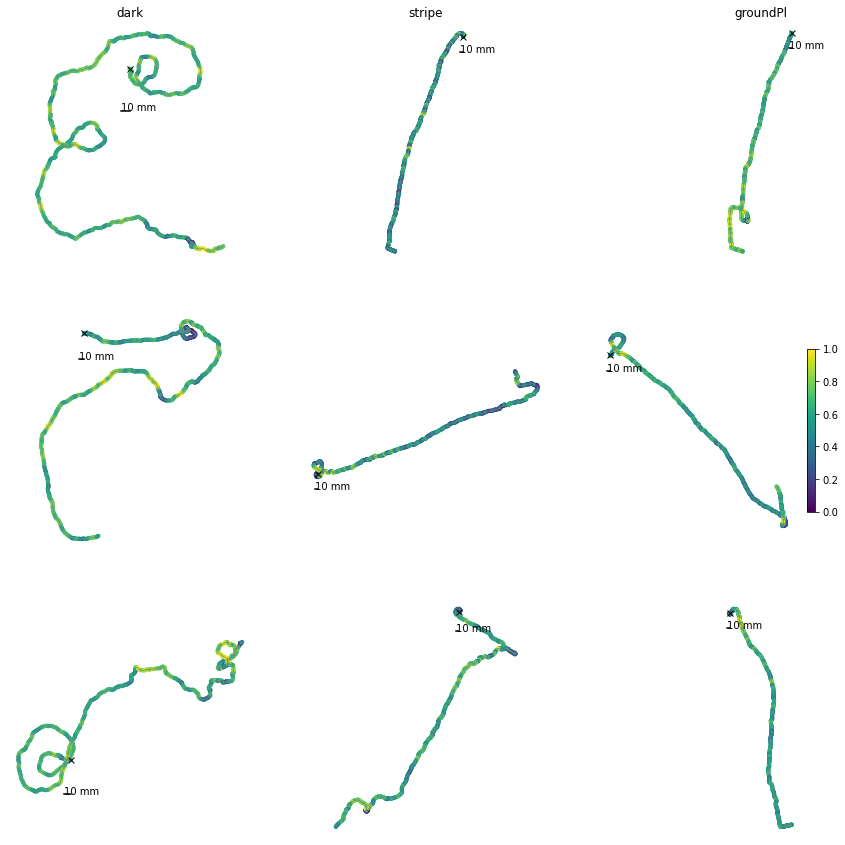

In [318]:
fig, axs = plt.subplots(numTrials,len(conditions),figsize=(15,15))
vlim = (0,1)#(1.8, 3.5)

trialcols = ['orange','yellowgreen','teal']
for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        subdf = singleFlyDf.query('condition == "{}" & trial == {}'.format(condition, trial+1))
        
        NOl = savgol_filter(subdf['NO1'].values, sgwindow, sgorder) 
        NOr = savgol_filter(subdf['NO2'].values, sgwindow, sgorder)
        vTfilt = savgol_filter(subdf['vTrans'].values, sgwindow, sgorder)

        NOsig = (NOl + NOr)
        # normalize
        NOsig = (NOsig-min(NOsig))/(max(NOsig)-min(NOsig))
        
        axs[trial,cond].plot(subdf['xpos'].values, subdf['ypos'].values,color='grey',linewidth=0.7)
        axs[trial,cond].plot(subdf['xpos'].values[0], subdf['ypos'].values[0],'x',color='k',linewidth=0.7)

        cb = axs[trial,cond].scatter(subdf['xpos'].values, subdf['ypos'].values, 
                                s=10, c=NOsig, vmin=vlim[0], vmax=vlim[1])
        
        wall = plt.Circle((0,0),arenarad, color='grey', fill=False)
        axs[trial,cond].add_artist(wall)
        minimalAxisTheme(axs[trial,cond],1,([-6, -5]),'10 mm')
        
    axs[0,cond].set_title(condition)
fig.colorbar(cb, ax=axs[:, -1], shrink=0.2)
fig.savefig(plotDir+sep+'{}_trajectoriesWithSumNOsignal.pdf'.format(pltstem))

#### Heading vs. PVA

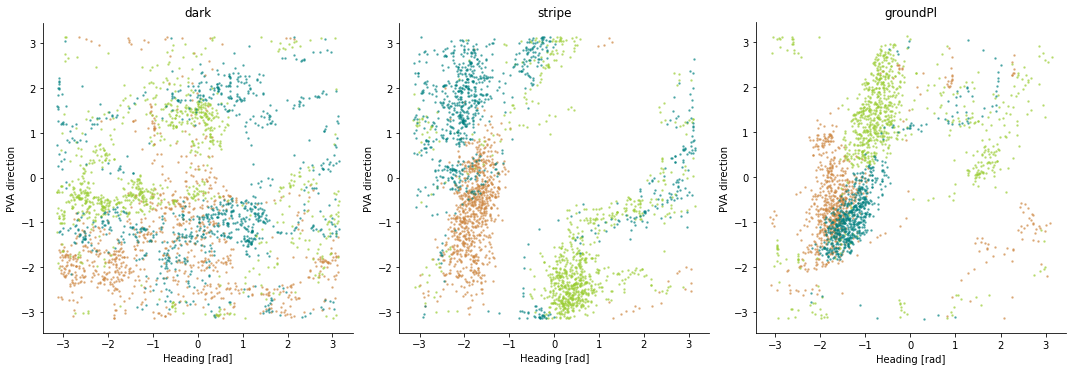

In [319]:
fig, axs = plt.subplots(1,len(conditions), figsize=(15,5))
roiArcPos = np.linspace(0, 2*np.pi, len(FBRois)+1)[:-1]

for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        subdf = singleFlydf.query('(condition == "{}") & ( trial == {}) & (abs(vTransFilt) >= {})'.format(\
                                                        condition, trial+1, vTransTH))
        axs[cond].plot(subdf['heading'].values,subdf['pvaRad'].values,'.', color=trialCols[trial], alpha=0.5, markersize=3)
        
    axs[cond].set_xlabel('Heading [rad]')
    axs[cond].set_ylabel('PVA direction')
    axs[cond].set_title(conditions[cond])
    axs[cond].set_aspect('equal')
    myAxisTheme(axs[cond])

fig.tight_layout()
fig.savefig(plotDir+sep+'{}_heading-vs-PVA.pdf'.format(pltstem))

### 3. Correlations with walking velocities
#### Cross correlation plot

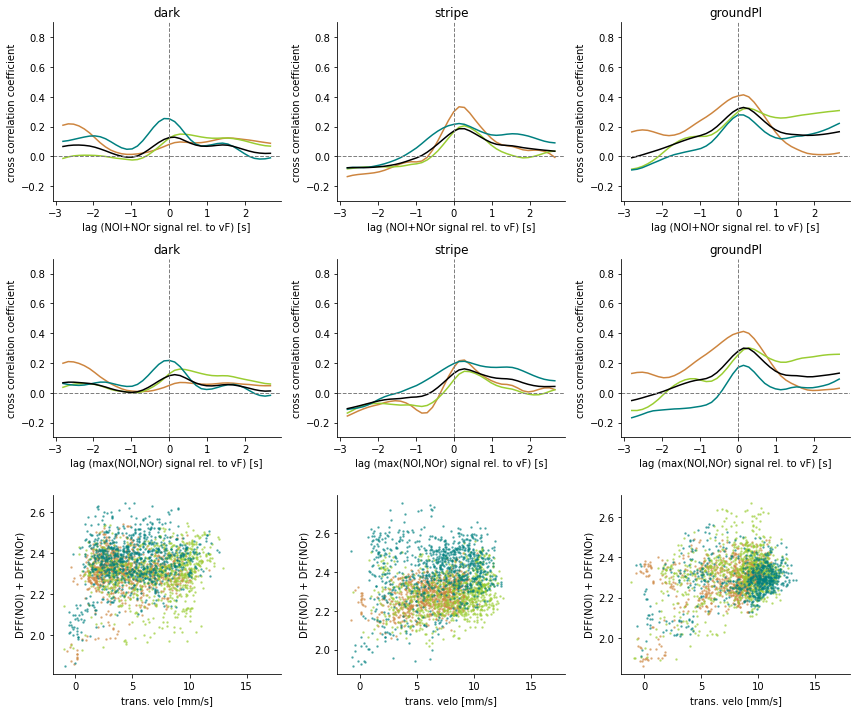

In [320]:
fig, axs = plt.subplots(3,len(conditions), figsize=(12,10))

lags = np.arange(-20, 20)

for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        subtdf = singleFlydf.query('(condition == "{}") & ( trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
        if len(subtdf['NO1'].values)<0.25*frameNum:
            print('Fly did not move enough')
            continue
        NOl = subtdf['dffNO1'].values
        NOr = subtdf['dffNO2'].values
        vTfilt = savgol_filter(subtdf['vTrans'].values, sgwindow, sgorder)

        NOsig1 = NOl + NOr
        NOsig2 = np.max([NOl,NOr], axis=0)
        
        # compute cross correlation
        ccVF = myxcorrCoeff(vTfilt,NOsig1,lags)
        axs[0,cond].plot(lags/vps, ccVF, color=trialCols[trial])   
        
        ccVF = myxcorrCoeff(vTfilt,NOsig2,lags)
        axs[1,cond].plot(lags/vps, ccVF, color=trialCols[trial])   
        
        axs[2,cond].plot(vTfilt, NOsig1,'.', color=trialCols[trial], alpha=0.5, markersize=3)
        
    subdf = singleFlydf.query('(condition == "{}") & ( abs(vTransFilt) >= {})'.format(condition,vTransTH))
    if len(subdf['NO1'].values)<0.25*frameNum*3:
        print('Fly did not move enough')
        continue
    NOl = savgol_filter(subdf['NO1'].values, sgwindow, sgorder) 
    NOr = savgol_filter(subdf['NO2'].values, sgwindow, sgorder)
    vTfilt = savgol_filter(subdf['vTrans'].values, sgwindow, sgorder)

    NOsig1 = NOl + NOr
    NOsig2 = np.max([NOl,NOr], axis=0)
    
    ccVF = myxcorrCoeff(vTfilt,NOsig1,lags)       
    axs[0,cond].plot(lags/vps, ccVF, color='black')
    
    ccVF = myxcorrCoeff(vTfilt,NOsig2,lags)       
    axs[1,cond].plot(lags/vps, ccVF, color='black')
    
    for i in range(2):
        axs[i,cond].set_title(conditions[cond])
        axs[i,cond].axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        axs[i,cond].axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        axs[i,cond].set_ylabel('cross correlation coefficient')
    
    axs[0,cond].set_xlabel('lag (NOl+NOr signal rel. to vF) [s]')
    axs[1,cond].set_xlabel('lag (max(NOl,NOr) signal rel. to vF) [s]')
    
    axs[2,cond].set_xlabel('trans. velo [mm/s]')
    axs[2,cond].set_ylabel('DFF(NOl) + DFF(NOr)')
    
for i in range(2):
    for ax in axs[i,:]:
        myAxisTheme(ax)
        ax.set_ylim(-0.3,0.9)
for ax in axs[2,:]:
    myAxisTheme(ax)
    ax.set_xlim(-2,18)

fig.tight_layout()
fig.savefig(plotDir+sep+'{}_crossCorr_vT-NO.pdf'.format(pltstem))

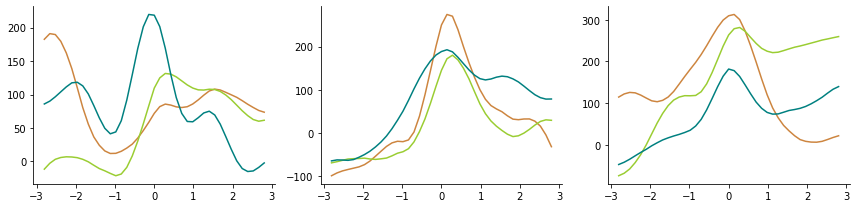

In [321]:
# alternative method using np.correlate... missing normalization to make it cross corr coeff though
fig, axs = plt.subplots(1,len(conditions), figsize=(12,3))

inds = np.arange(-20, 20+1)
window = inds/vps

numPts = ROIdat.shape[1]
for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        subdf = singleFlydf.query('(condition == "{}") & ( trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
        if len(subdf['NO1'].values)<0.25*frameNum:
            print('Fly did not move enough')
            continue
        NOsig = savgol_filter(subdf['NO1'].values, sgwindow, sgorder) + savgol_filter(subdf['NO2'].values, sgwindow, sgorder)
        NOsig_z = sts.zscore(NOsig)
        vTfilt_z = sts.zscore(subdf['vTransFilt'])
        
        # compute cross correlation
        ccVF = np.correlate(vTfilt_z, NOsig_z,'same')
        axs[cond].plot(window, ccVF[int(len(ccVF)/2)+inds[0]:int(len(ccVF)/2)+inds[-1]+1], color=trialCols[trial])

    for ax in axs:
        myAxisTheme(ax)
fig.tight_layout()

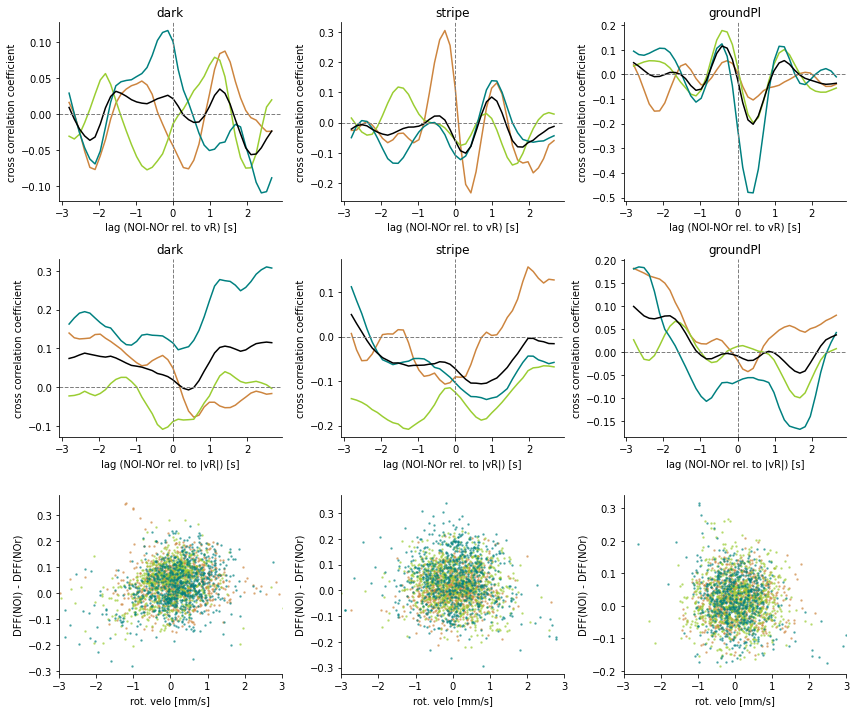

In [322]:
fig, axs = plt.subplots(3,len(conditions), figsize=(12,10))

lags = np.arange(-20, 20)

for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        subtdf = singleFlydf.query('(condition == "{}") & ( trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
        if len(subtdf['NO1'].values)<0.25*frameNum:
            print('Fly did not move enough')
            continue
        NOl = subtdf['dffNO1'].values
        NOr = subtdf['dffNO2'].values
        vfilt = savgol_filter(subtdf['vRot'].values, sgwindow, sgorder)

        NOsig1 = NOl - NOr
        
        # compute cross correlation
        ccVF = myxcorrCoeff(vfilt,NOsig1,lags)
        axs[0,cond].plot(lags/vps, ccVF, color=trialCols[trial])   
        
        ccVF = myxcorrCoeff(abs(vfilt),NOsig1,lags)
        axs[1,cond].plot(lags/vps, ccVF, color=trialCols[trial])   
        
        axs[2,cond].plot(vfilt, NOsig1,'.', color=trialCols[trial], alpha=0.5, markersize=3)
        
    subdf = singleFlydf.query('(condition == "{}") & ( abs(vTransFilt) >= {})'.format(condition,vTransTH))
    if len(subdf['NO1'].values)<0.25*frameNum*3:
        print('Fly did not move enough')
        continue
    NOl = subdf['dffNO1'].values 
    NOr = subdf['dffNO2'].values
    vfilt = savgol_filter(subdf['vRot'].values, sgwindow, sgorder)

    NOsig1 = NOl - NOr
    
    ccVF = myxcorrCoeff(vfilt,NOsig1,lags)       
    axs[0,cond].plot(lags/vps, ccVF, color='black')
    
    ccVF = myxcorrCoeff(abs(vfilt),NOsig1,lags)       
    axs[1,cond].plot(lags/vps, ccVF, color='black')
    
    for i in range(2):
        axs[i,cond].set_title(conditions[cond])
        axs[i,cond].axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        axs[i,cond].axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        axs[i,cond].set_ylabel('cross correlation coefficient')
    
    axs[0,cond].set_xlabel('lag (NOl-NOr rel. to vR) [s]')
    axs[1,cond].set_xlabel('lag (NOl-NOr rel. to |vR|) [s]')
    
    axs[2,cond].set_xlabel('rot. velo [mm/s]')
    axs[2,cond].set_ylabel('DFF(NOl) - DFF(NOr)')
    
for i in range(2):
    for ax in axs[i,:]:
        myAxisTheme(ax)
        #ax.set_ylim(-0.3,0.9)
for ax in axs[2,:]:
    myAxisTheme(ax)
    ax.set_xlim(-3,3)

fig.tight_layout()
fig.savefig(plotDir+sep+'{}_crossCorr_vR-NO.pdf'.format(pltstem))

#### TODO: use cross correlation to identify the phaseshift that corresponds to the best alignment between the two signals
#### Potentially need a different method, since relationship not necessarily linear (because of imperfections of ROI drawing and potentially individual tuning of neurons)

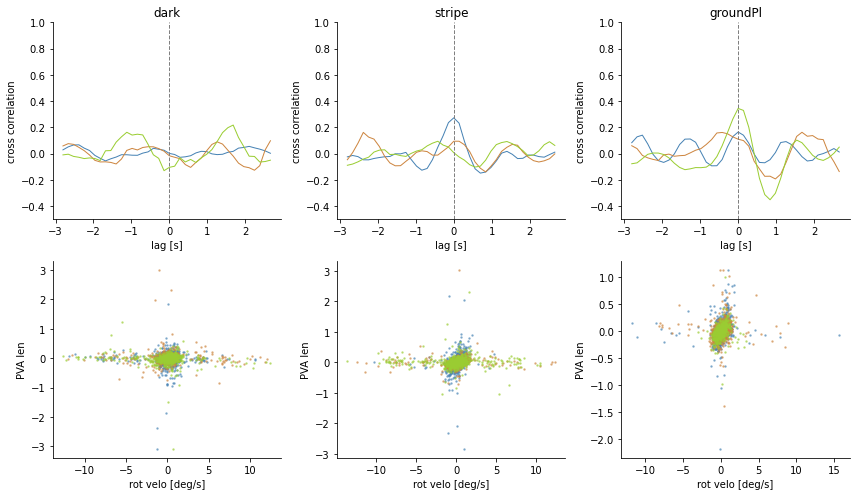

In [323]:
fig, axs = plt.subplots(2,len(conditions), figsize=(12,7))
trialCols = ['steelblue', 'peru', 'yellowgreen']

inds = np.arange(-30,30+1)
window = inds/vps

numPts = ROIdat.shape[1]

for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        
        subdf = singleFlydf.query('(condition == "{}") & (trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
        
        roidatFB = np.zeros((len(FBRois),len(subdf['time'].values)))
        for i in range(len(FBRois)):
            roidatFB[i,:] = subdf['FB{}'.format(i+1)].values
            roidatFB[i,:]= savgol_filter(roidatFB[i,:], sgwindow, sgorder)

        pva = computePVA(roiArcPos,roidatFB)
        pvaRad = np.arctan2(pva[1,:],pva[0,:])
        pvaLen = np.hypot(pva[0,:],pva[1,:])
        
        vR = savgol_filter(subdf['vRot'].values, sgwindow, sgorder)
        pvaSig = np.hstack((0,np.diff(np.unwrap(pvaRad))))
        
        # compute cross correlation
        ccVF = np.correlate(vR, pvaSig,'same')
        ccVF, pvals = myxcorrCoeffPval(vR, pvaSig,lags) 
        axs[0,cond].plot(lags/vps, ccVF, color=trialCols[trial], linewidth=1)
        axs[1,cond].plot(vR,pvaSig,'.', color=trialCols[trial], alpha=0.5, markersize=3)
        

    axs[0,cond].set_title(conditions[cond])
    axs[0,cond].set_ylim(-0.5, 1)
    axs[0,cond].axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
    axs[0,cond].set_xlabel('lag [s]')
    axs[0,cond].set_ylabel('cross correlation')
    
    for ax in axs[:,cond]:

        myAxisTheme(ax)
        
    axs[1,cond].set_xlabel('rot velo [deg/s]')
    axs[1,cond].set_ylabel('PVA len')
        
fig.tight_layout()
#fig.savefig(plotDir+sep+'{}_crossCorr_vT-NO.pdf'.format(stem))

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/haberkernh/an

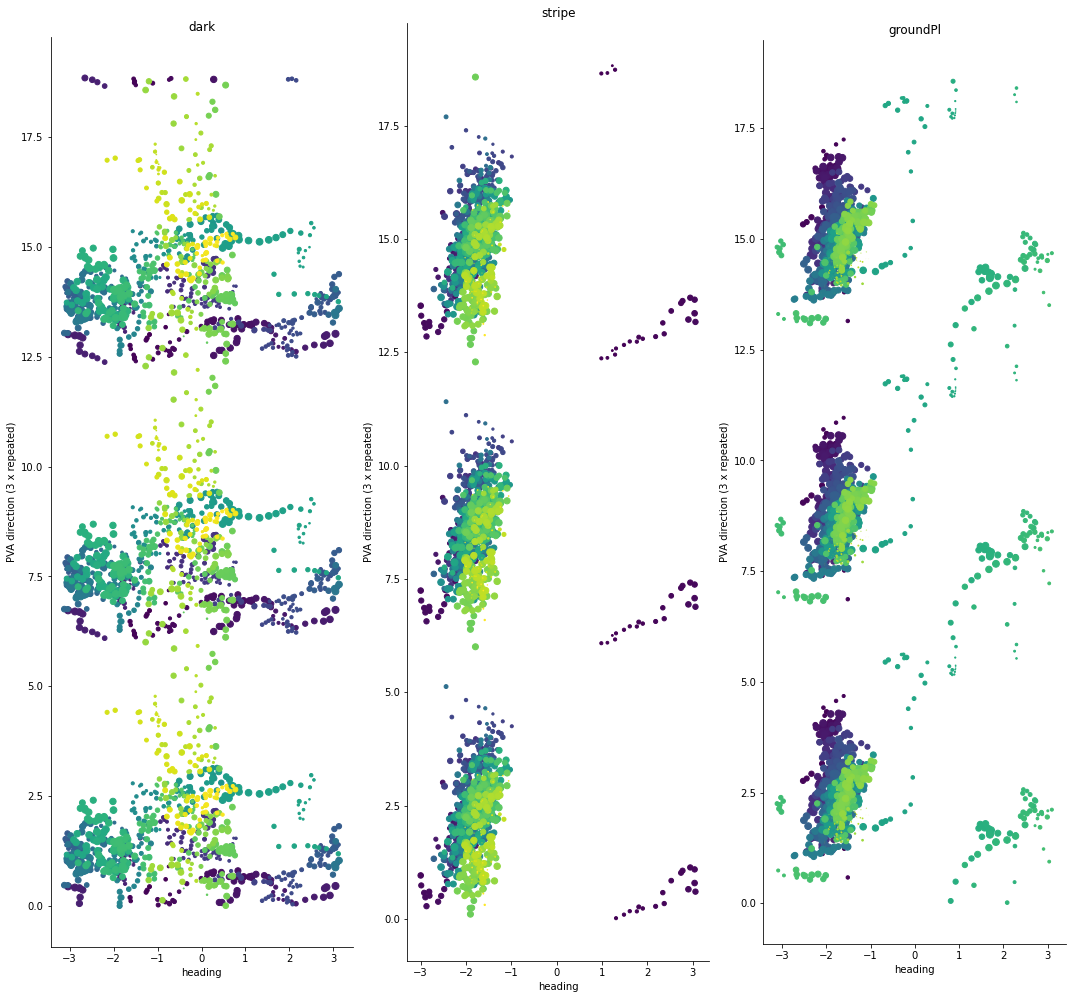

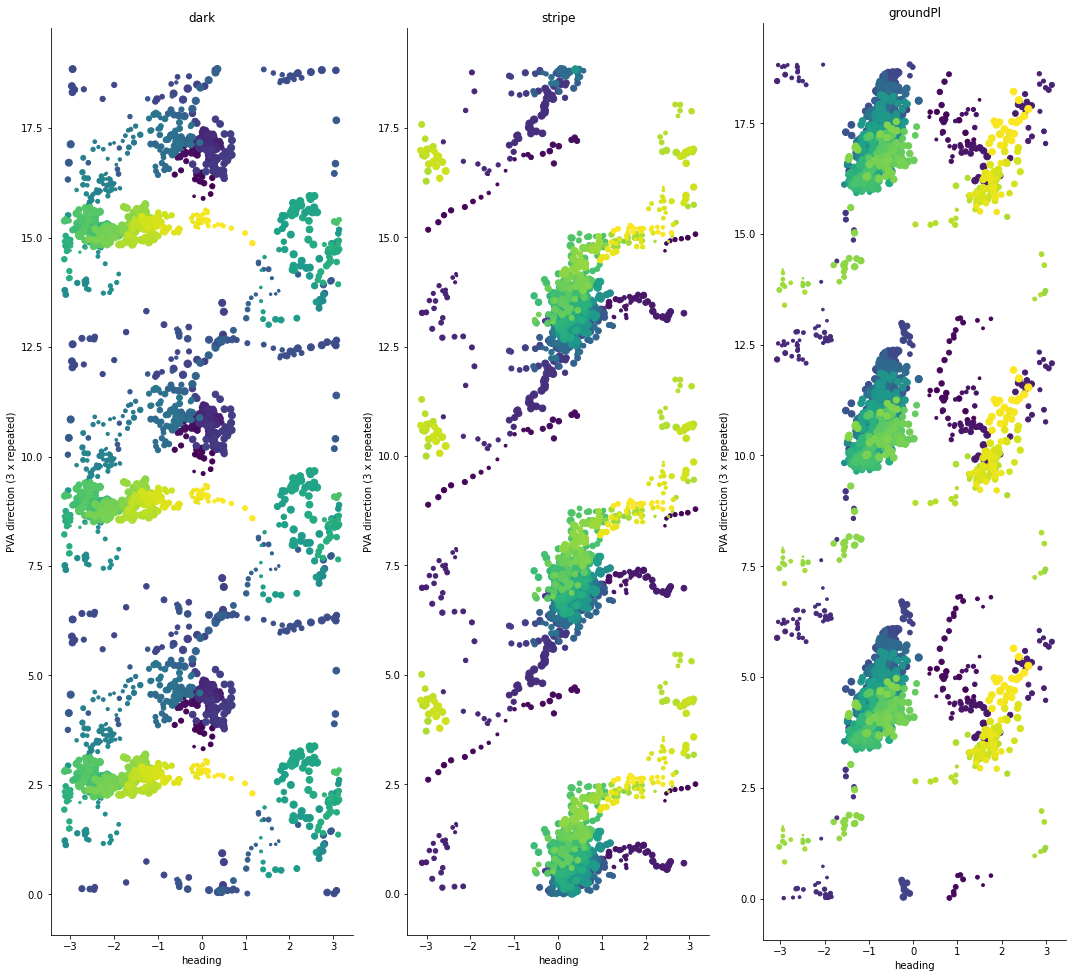

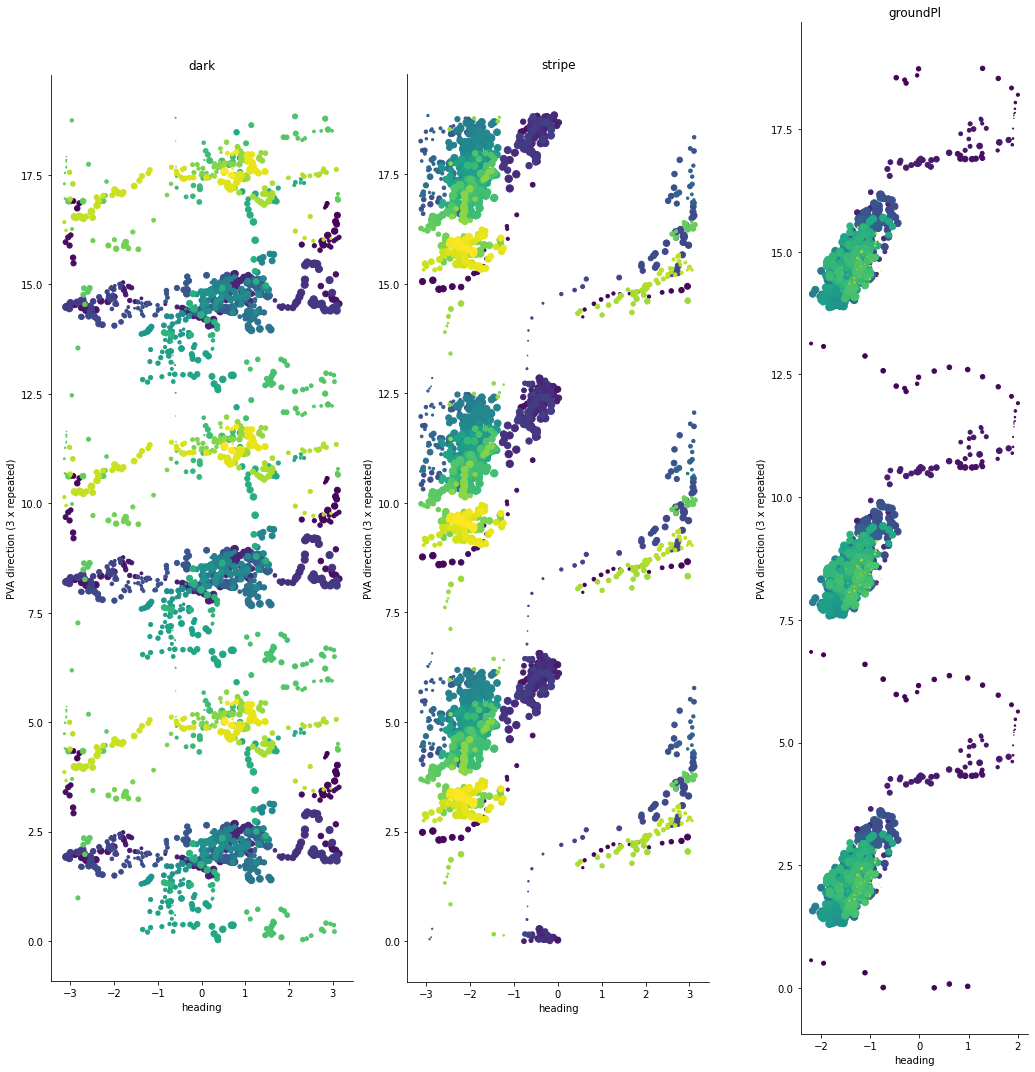

In [324]:
#with plt.style.context(('dark_background')):
for trial in range(numTrials):

    fig, axs = plt.subplots(1,len(conditions), figsize=(15,15))

    for cond, condition in enumerate(conditions):
        
        subdf = singleFlydf.query('(condition == "{}") & ( trial == {})'.format(condition, trial+1))

        for i in range(3):
            cb = axs[cond].scatter(subdf['heading'], subdf['pvaRad']+(i+0.5)*np.pi*2,
                      s=5*subdf['vTransFilt'],c=subdf['time'], cmap='viridis') #'YlGnBu'

        axs[cond].set_xlabel('heading')
        axs[cond].set_ylabel('PVA direction (3 x repeated)')
        axs[cond].set_title(conditions[cond])
        axs[cond].set_aspect('equal')

    for ax in axs:
        myAxisTheme(ax)

    #plt.colorbar(cb, label='Time [s]')
    fig.tight_layout()
    fig.savefig(plotDir+sep+'heading2PVAMap_darkPlot_{}_t0{}.pdf'.format(flyID, trial+1))

## Realign head direction readout in FB based on NO input + connectivity offset
#### Visualize ROIs

In [325]:
cond = 1
trial = 1

datName = '_'.join([pltstem, conditions[cond],str(trial+1).zfill(5)])
print(datName)

roiMat = sio.loadmat(sep.join([dataDir,'preprocData', flyID,datName+'_ROIs.mat']))
roiShapes = roiMat['ROIs'][0][0]
numRois = roiShapes.shape[0]

#roiCols = ['firebrick', 'teal', 'salmon', 'lightseagreen']

SS78_GCaMP7f_f09_4-5d_FB_stripe_00002


In [326]:
refTif = sep.join([dataDir,'rawData','imaging',flyID,datName+'.tif'])

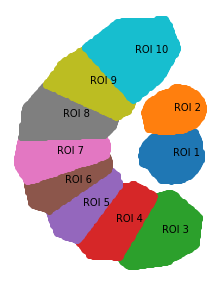

In [327]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
for i in range(numRois):
    roi1 = roiShapes[i]
    axs.scatter(np.where(roi1)[0],np.where(roi1)[1]) #color =  roiCols[i]
    axs.text(np.mean(np.where(roi1)[0]),np.mean(np.where(roi1)[1]),'ROI {}'.format(i+1))
axs.set_aspect('equal')
axs.axis('off');

fig.savefig(plotDir+sep+stem+'_ROIlegend_dff_{}_{}_t{}.pdf'.format(flyID, conditions[cond], trial+1))


#Bottom NO is left, top NO is right

### PFNd (SS78) offset

In [328]:
trial = 2
condition = conditions[1]
subdf = singleFlydf.query('(condition == "{}") & ( trial == {})'.format(condition, trial+1))

In [329]:
t = subdf['time'].values

NOl = savgol_filter(subdf['NO1'].values, sgwindow, sgorder) 
NOr = savgol_filter(subdf['NO2'].values, sgwindow, sgorder)
nosig = NOl-NOr#savgol_filter(NOl-NOr, sgwindow, sgorder)
head = subdf.heading.values
pva = subdf.pvaRad.values

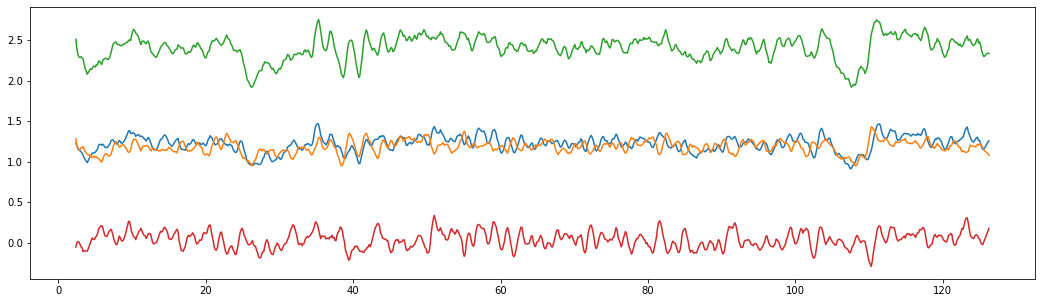

In [330]:
fig, axs = plt.subplots(1,1, figsize=(18,5))
axs.plot(t, NOl)
axs.plot(t, NOr)
axs.plot(t, NOr+NOl)
axs.plot(t, nosig)

In [331]:
pvacorr = np.unwrap(pva + np.pi)
pvacorr[nosig >=  0] = (pvacorr[nosig >= 0] + (1/np.max(nosig))*nosig[nosig >= 0]*np.pi*2/8 )
pvacorr = np.mod(pvacorr, 2*np.pi) - np.pi
pvacorr[abs(NOl+NOr) <= 2.2] = np.nan*np.ones(pvacorr[abs(NOl+NOr) <= 2.2].size)

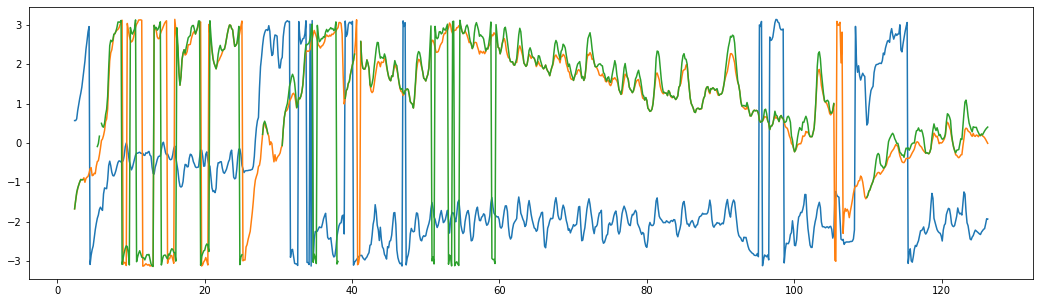

In [332]:
fig, axs = plt.subplots(1,1, figsize=(18,5))
axs.plot(t, head)
axs.plot(t, pva)
axs.plot(t, pvacorr)

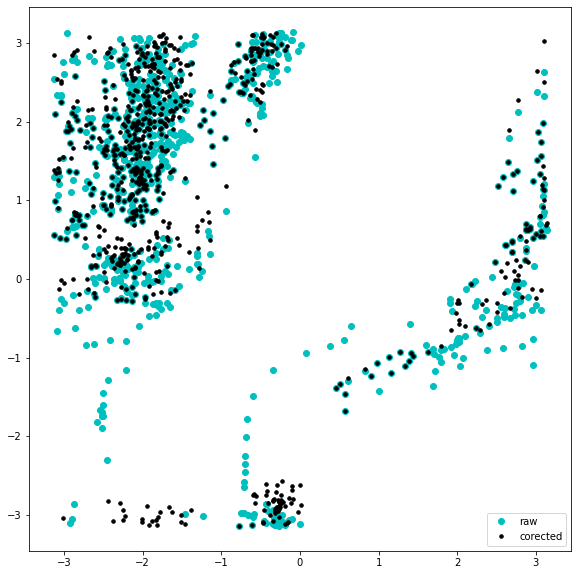

In [333]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
axs.plot(head, pva, 'co', label='raw')
axs.plot(head, pvacorr, 'k.', label='corected', markersize=7)
axs.set_aspect('equal')
plt.legend()

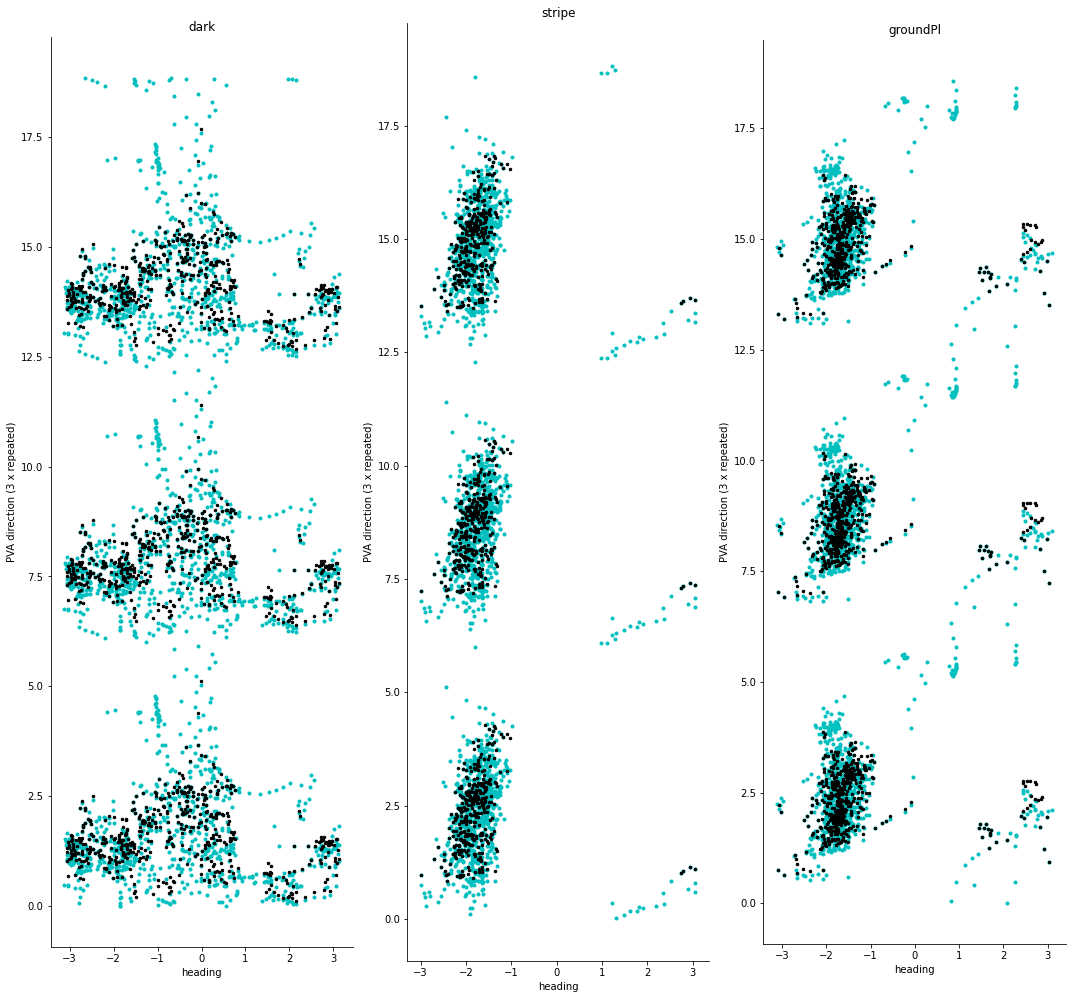

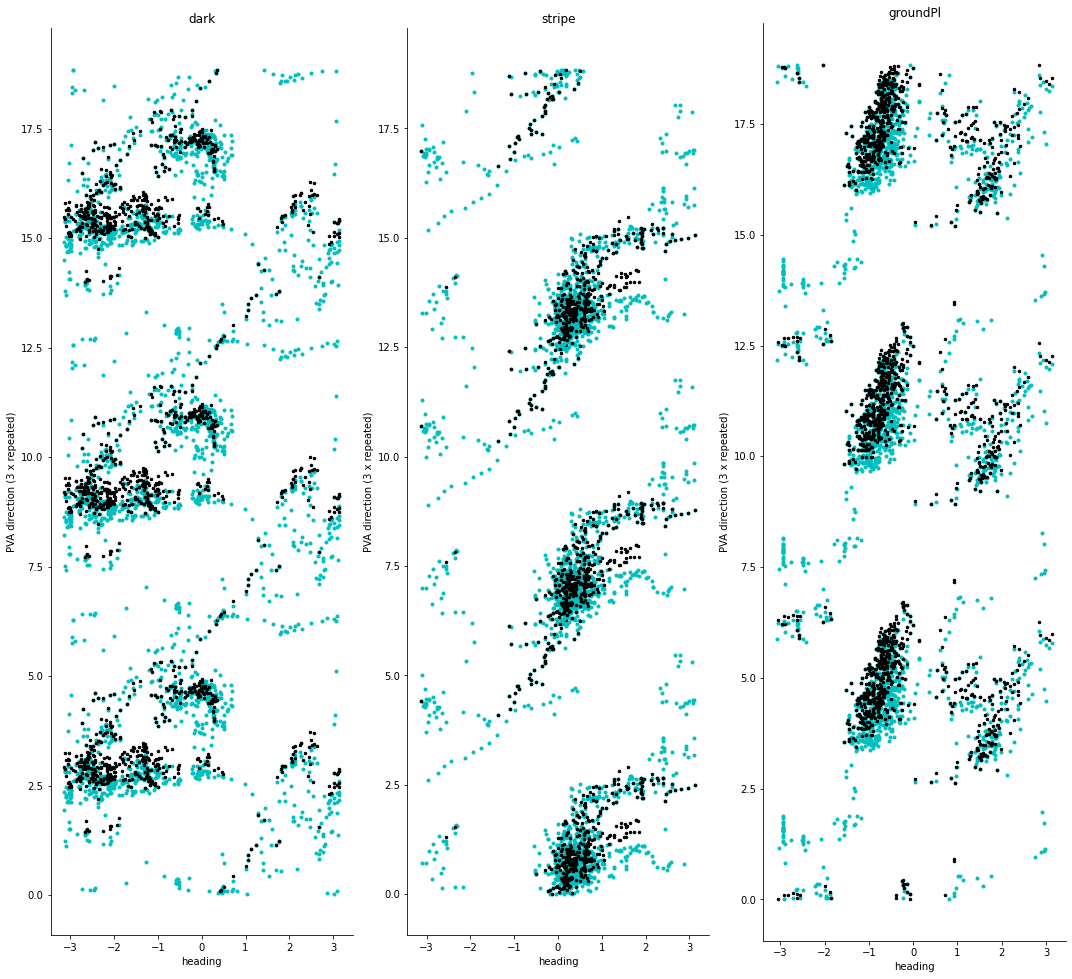

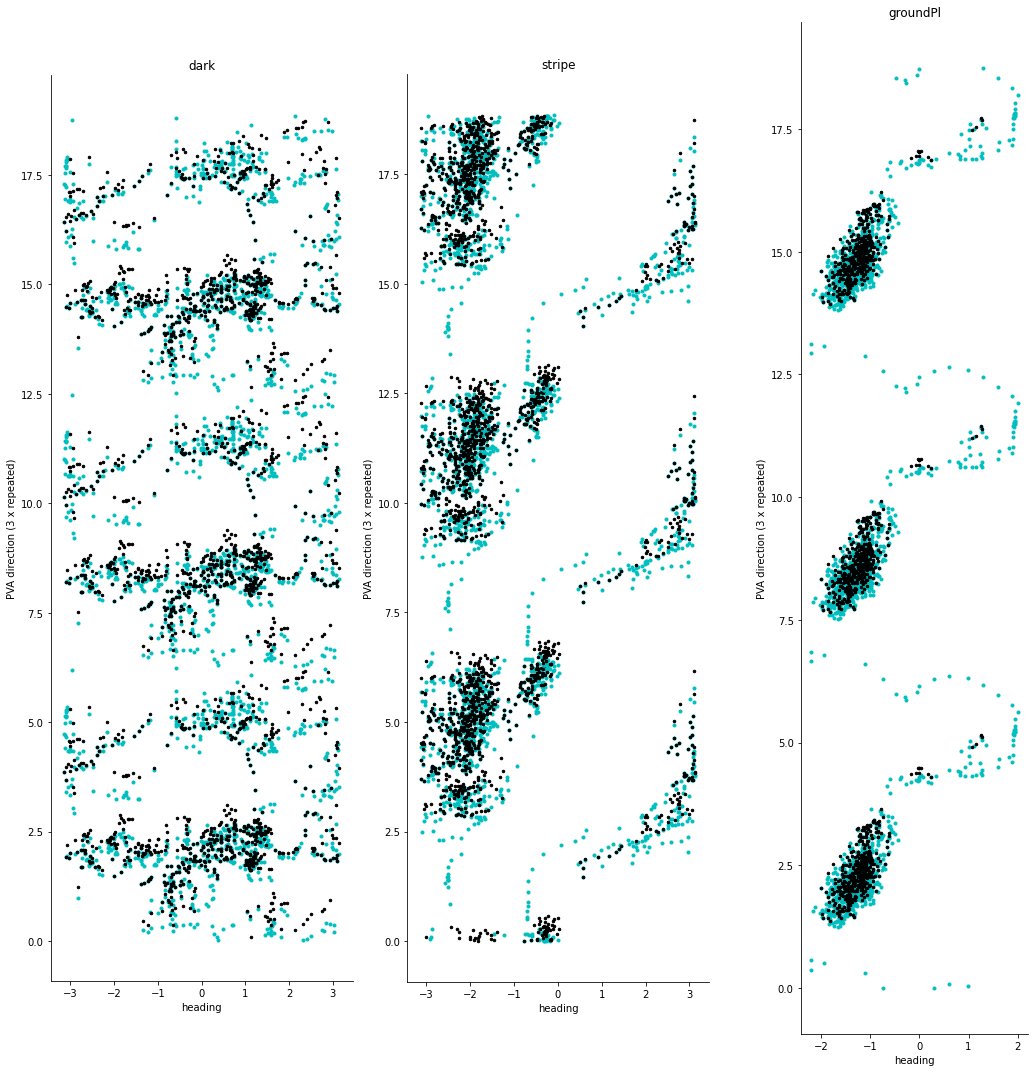

In [339]:
noth = 2.3
for trial in range(numTrials):

    fig, axs = plt.subplots(1,len(conditions), figsize=(15,15))

    for cond, condition in enumerate(conditions):
        
        subdf = singleFlydf.query('(condition == "{}") & ( trial == {})'.format(condition, trial+1))
        t = subdf['time'].values

        NOl = savgol_filter(subdf['NO1'].values, sgwindow, sgorder) 
        NOr = savgol_filter(subdf['NO2'].values, sgwindow, sgorder)
        nosig = NOl-NOr#savgol_filter(NOl-NOr, sgwindow, sgorder)
        head = subdf.heading.values
        pva = subdf.pvaRad.values
        
        pvacorr = np.unwrap(pva + np.pi)
        pvacorr[nosig >=  0] = (pvacorr[nosig >= 0] + (1/np.max(nosig))*nosig[nosig >= 0]*np.pi*2/8 )
        pvacorr = np.mod(pvacorr, 2*np.pi) - np.pi
        pvacorr[abs(NOl+NOr) <= noth] = np.nan*np.ones(pvacorr[abs(NOl+NOr) <= noth].size)

        for i in range(3):
            axs[cond].plot(head, pva+(i+0.5)*np.pi*2,'o', color='c', markersize=3)
            axs[cond].plot(head, pvacorr+(i+0.5)*np.pi*2,'.', color='k', markersize=5)
            #cb = axs[cond].scatter(head, pvacorr+(i+0.5)*np.pi*2,
            #          s=10,c=t, cmap='viridis') #'YlGnBu'

        axs[cond].set_xlabel('heading')
        axs[cond].set_ylabel('PVA direction (3 x repeated)')
        axs[cond].set_title(conditions[cond])
        axs[cond].set_aspect('equal')

    for ax in axs:
        myAxisTheme(ax)

    #plt.colorbar(cb, label='Time [s]')
    fig.tight_layout()

In [279]:
from sympy import *
x = symbols('x')
a = Integral(cos(x)*exp(x), x)
Eq(a, a.doit())

Eq(Integral(exp(x)*cos(x), x), exp(x)*sin(x)/2 + exp(x)*cos(x)/2)